# Prototype of the data processing pipeline

Goals: 
Generate stereo image pairs and object transforms.

In [51]:
import numpy as np
import trimesh 
import pyrender
import doctest
import pickle
import os.path as osp
from scipy.spatial.transform import Rotation as R

from util import make_rotation_matrix
import util

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [33]:
shapenet_categories = {'mug': '03797390',
    'bowl': '02880940',
    'bottle': '02876657'}

shapenet_id = '1eaf8db2dd2b710c7d5b1b70ae595e60'

data_dir = "../data"
mug_occ_dict = pickle.load(open(osp.join(data_dir,
    'training_data/occ_shapenet_mug.p'), "rb"))

demo_mesh_fname = osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj')

# Render Images

### Camera Definition
<div>
<img src="./prototype_resources/cam_layout.jpeg" width="500"/>
</div>

In [108]:
def make_camera_pose(r, theta):
    """
    Make homologous camera pose matrix using r and theta according to 
    diagram above.

    Args:
        r (float): Radius of cameras from scene orgin, unit is meters.
        theta (float): Angle of camera from z axis, unit is radians.
    >>> np.array_equal(make_camera_pose(1, 0), \
    np.array([[ 1.,  0.,  0.,  0.], \
              [ 0.,  1.,  0.,  0.], \
              [ 0.,  0.,  1.,  1.], \
              [ 0.,  0.,  0.,  1.]]))

    True
    """
    l_z = r * np.cos(theta)
    l_x = r * np.sin(theta)
    rotation = make_rotation_matrix('y', theta)

    pose_mat = np.eye(4)
    pose_mat[:3, :3] = rotation
    pose_mat[:3, 3] = np.array([l_x, 0, l_z])

    return pose_mat

# doctest.testmod()

In [172]:
def render_mesh(mesh_fname, n_samples=1000, cam_r=1, cam_theta=np.pi/16):
    """
    Render mesh in random poses.

    Note: If getting a display error, try 
    `os.environ['PYOPENGL_PLATFORM'] = 'egl'`

    Args:
        mesh_fname (string): path to mesh file
        n_samples (int, optional): Number of random poses to sample. Defaults to 1000.

    Returns:
        Tuple(np.array, np.array, np.array): Left image, right image, object pose
    """
    # -- Load mesh -- #
    mesh = trimesh.load(mesh_fname)
    scene = pyrender.Scene()
    renderer = pyrender.OffscreenRenderer(400, 400)
    baseColorFactor = [210, 210, 210, 1]
    texture = pyrender.MetallicRoughnessMaterial('mug_material', baseColorFactor=baseColorFactor) 
    mesh_node = scene.add(pyrender.Mesh.from_trimesh(mesh, material=texture))

 
    # -- Define Cameras -- #
    l_cam_pose = make_camera_pose(cam_r, -cam_theta)
    r_cam_pose = make_camera_pose(cam_r, cam_theta)

    camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
    l_cam_node = scene.add(camera, pose=l_cam_pose)
    r_cam_node = scene.add(camera, pose=r_cam_pose)

    # -- Define Lights -- #
    light = pyrender.SpotLight(color=np.ones(3), 
                               intensity=3.0, 
                               innerConeAngle=np.pi/16.0, 
                               outerConeAngle=np.pi/6.0)
    scene.add(light, pose=l_cam_pose)
    scene.add(light, pose=r_cam_pose)

    # -- Render -- #
    color_l_images = []
    color_r_images = []
    object_poses = []
    for i in range(n_samples):
        random_pose = np.eye(4)
        random_pose[:3, :3] = R.random().as_matrix()
        scene.set_pose(mesh_node, pose=random_pose)

        scene.main_camera_node = l_cam_node
        color_l, depth_l = renderer.render(scene)
        scene.main_camera_node = r_cam_node
        color_r, depth_r = renderer.render(scene)

        color_l_images.append(color_l)
        color_r_images.append(color_r)
        object_poses.append(random_pose)
    
    renderer.delete()
    return color_l_images, color_r_images, object_poses

In [173]:
def plot_image_lists(l_images, r_images):
    """
    Plot list of images side by side.

    Args:
        l_images (list): List of left images
        r_images (list): List of right images
    """
    import matplotlib.pyplot as plt
    im_dim = 2
    fig, axs = plt.subplots(len(l_images), 2, figsize=(2 * im_dim, len(l_images) * im_dim))
    for i in range(len(l_images)):
        axs[i, 0].imshow(l_images[i])
        axs[i, 1].imshow(r_images[i])
    plt.show()

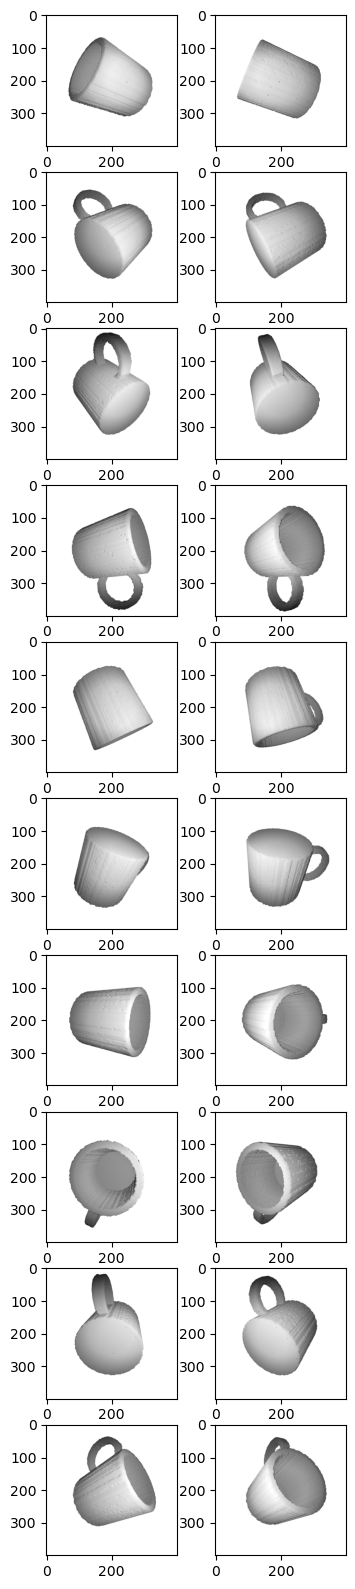

In [174]:
l_images, r_images, object_poses = render_mesh(demo_mesh_fname, 10)
plot_image_lists(l_images, r_images)